In [1405]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')



# Data Preprocessing

Загрузим данные

In [1406]:
data_dir = Path(".")
df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
df = pd.concat([df_train, df_test])

In [1407]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


Отделим числовые и категориальные переменные

In [1408]:
features_s = df.drop('SalePrice', axis=1).dtypes

In [1409]:
features_s.value_counts()

object     43
int64      25
float64    11
dtype: int64

In [1410]:
cat_features = features_s[features_s == 'object'].index

In [1411]:
num_features = features_s[features_s != 'object'].index

In [1412]:
cat_features

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [1413]:
num_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

# Целевая

array([[<AxesSubplot: title={'center': 'price'}>,
        <AxesSubplot: title={'center': 'log(price + 1)'}>]], dtype=object)

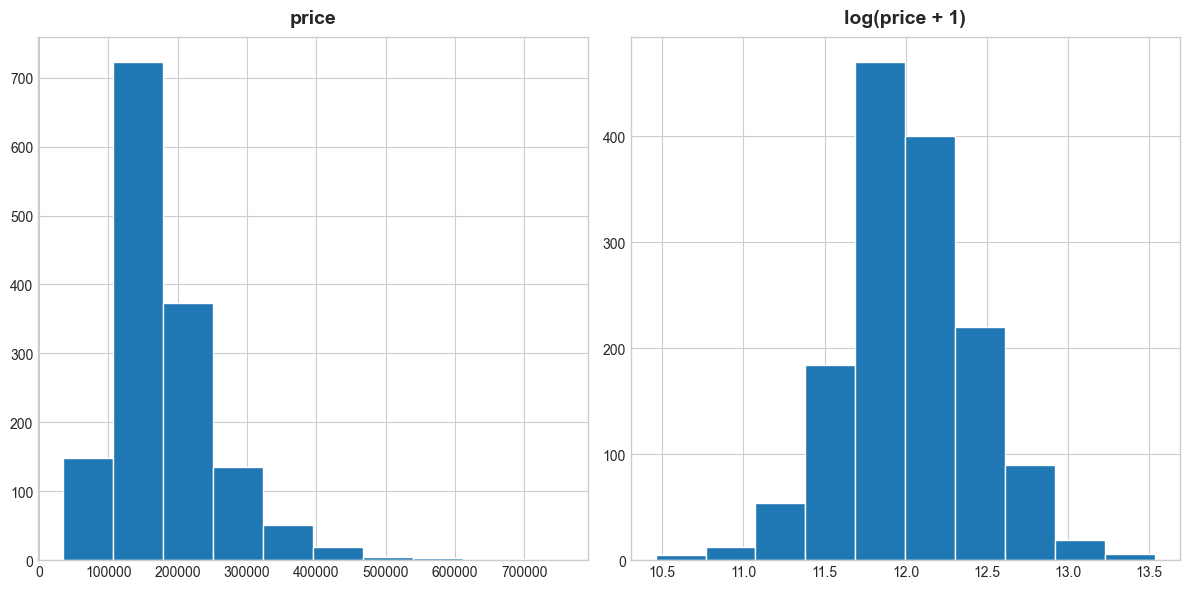

In [1414]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":df_train["SalePrice"], "log(price + 1)":np.log1p(df_train["SalePrice"])})
prices.hist()

### Заменим таргет

In [1415]:
df_train['target'] = np.log1p(df_train["SalePrice"])

### Посмотрим корреляцию

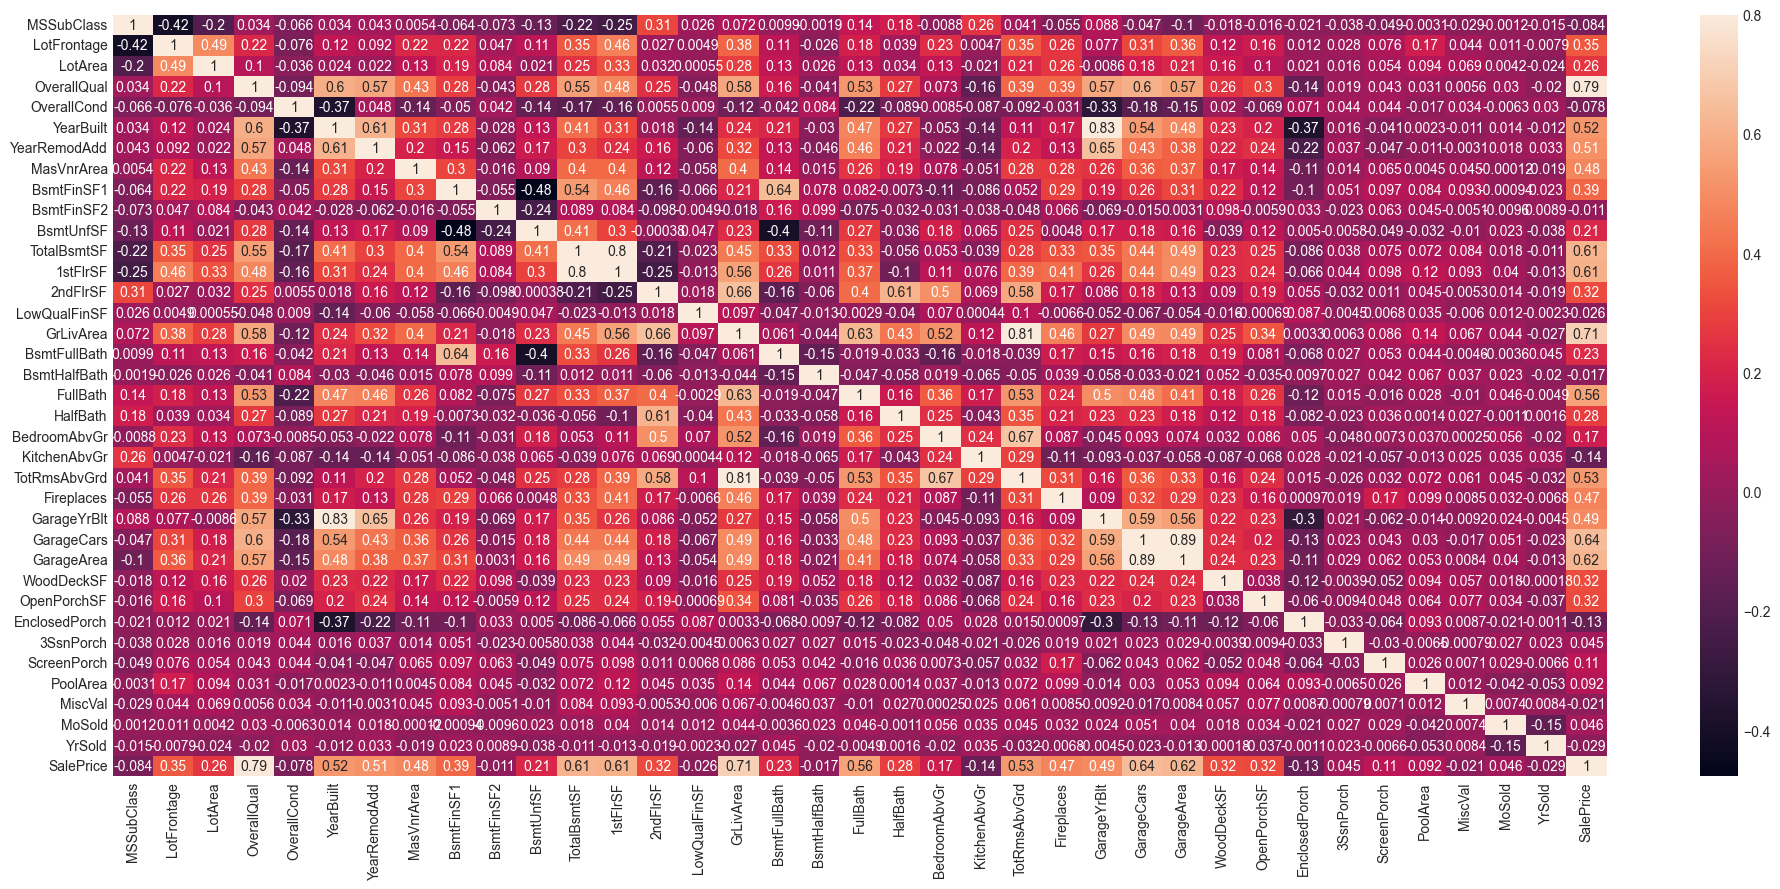

In [1416]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=.8, annot=True);

### Отберем те, которые сильнее всего коррелируют

In [1417]:
top_corr_features = list(corrmat.index[abs(corrmat["SalePrice"])>0.5])

In [1418]:
top_corr_features

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'SalePrice']

# Пропуски

In [1419]:
df[top_corr_features].describe()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
count,2919.000000,2919.000000,2919.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2918.000000,2918.000000,1460.000000
mean,6.089072,1971.312778,1984.264474,1051.777587,1159.581706,1500.759849,1.568003,6.451524,1.766621,472.874572,180921.195890
std,1.409947,30.291442,20.894344,440.766258,392.362079,506.051045,0.552969,1.569379,0.761624,215.394815,79442.502883
min,1.000000,1872.000000,1950.000000,0.000000,334.000000,334.000000,0.000000,2.000000,0.000000,0.000000,34900.000000
25%,5.000000,1953.500000,1965.000000,793.000000,876.000000,1126.000000,1.000000,5.000000,1.000000,320.000000,129975.000000
50%,6.000000,1973.000000,1993.000000,989.500000,1082.000000,1444.000000,2.000000,6.000000,2.000000,480.000000,163000.000000
75%,7.000000,2001.000000,2004.000000,1302.000000,1387.500000,1743.500000,2.000000,7.000000,2.000000,576.000000,214000.000000
max,10.000000,2010.000000,2010.000000,6110.000000,5095.000000,5642.000000,4.000000,15.000000,5.000000,1488.000000,755000.000000


In [1420]:
df[top_corr_features] = df[top_corr_features].fillna(df[top_corr_features].mean())

In [1421]:
# Распределения и корреляции

In [1422]:
# sns.set()
# cols = top_corr_features
# sns.pairplot(df[cols])
# plt.show();

In [1423]:
logfeatures = ['TotRmsAbvGrd', 'GarageArea', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF']

In [1424]:
for feature in logfeatures:
    df[feature] = np.log1p(df[feature])

In [1425]:
# sns.set()
# cols = top_corr_features
# sns.pairplot(df[cols])
# plt.show();

## Дропнем таргет

In [1426]:
top_corr_features.remove('SalePrice')

## Разделим датасеты

In [1427]:
#creating matrices for sklearn:
X_train = df[:df_train.shape[0]][top_corr_features]
X_test = df[df_train.shape[0]:][top_corr_features]
y = df_train['target']

## ~~Найдем~~ Напишем функцию подсчета скора на CV

In [1428]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# Линрег с регуляризацией

In [1429]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]


Text(0, 0.5, 'rmse')

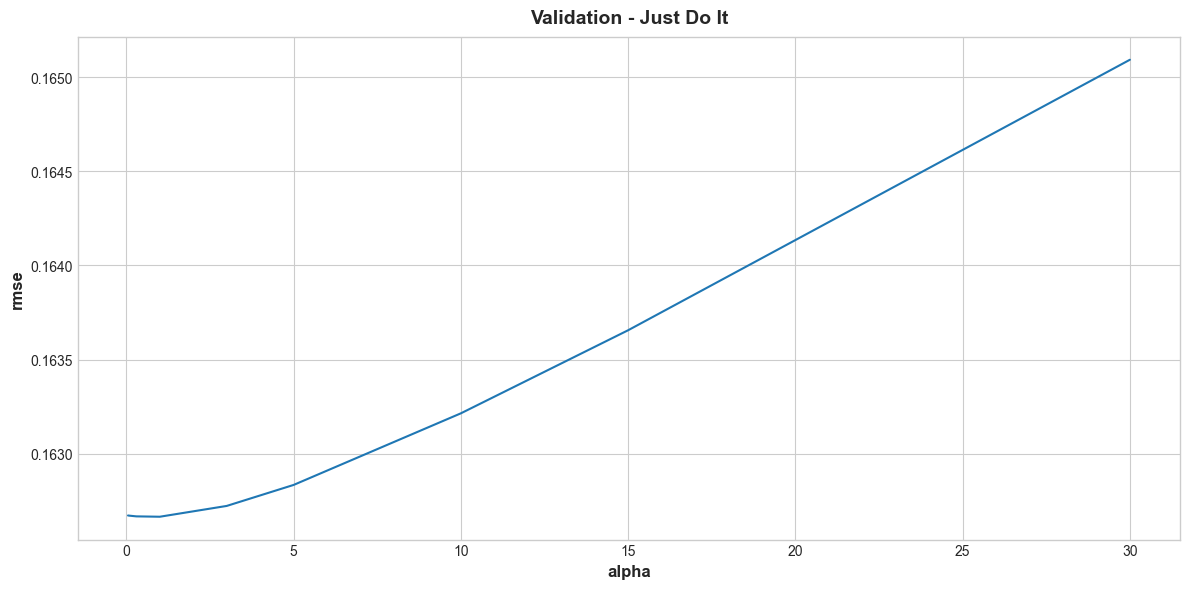

In [1430]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [1431]:
cv_ridge.min()

0.16266448818988527

# А если не париться с распределением

In [1432]:
#creating matrices for sklearn:
X_train = df_train[top_corr_features]
X_test = df_test[top_corr_features]
y = df_train['target']

In [1433]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]



In [1434]:
min(cv_ridge)

0.17322255141875845

# Binning

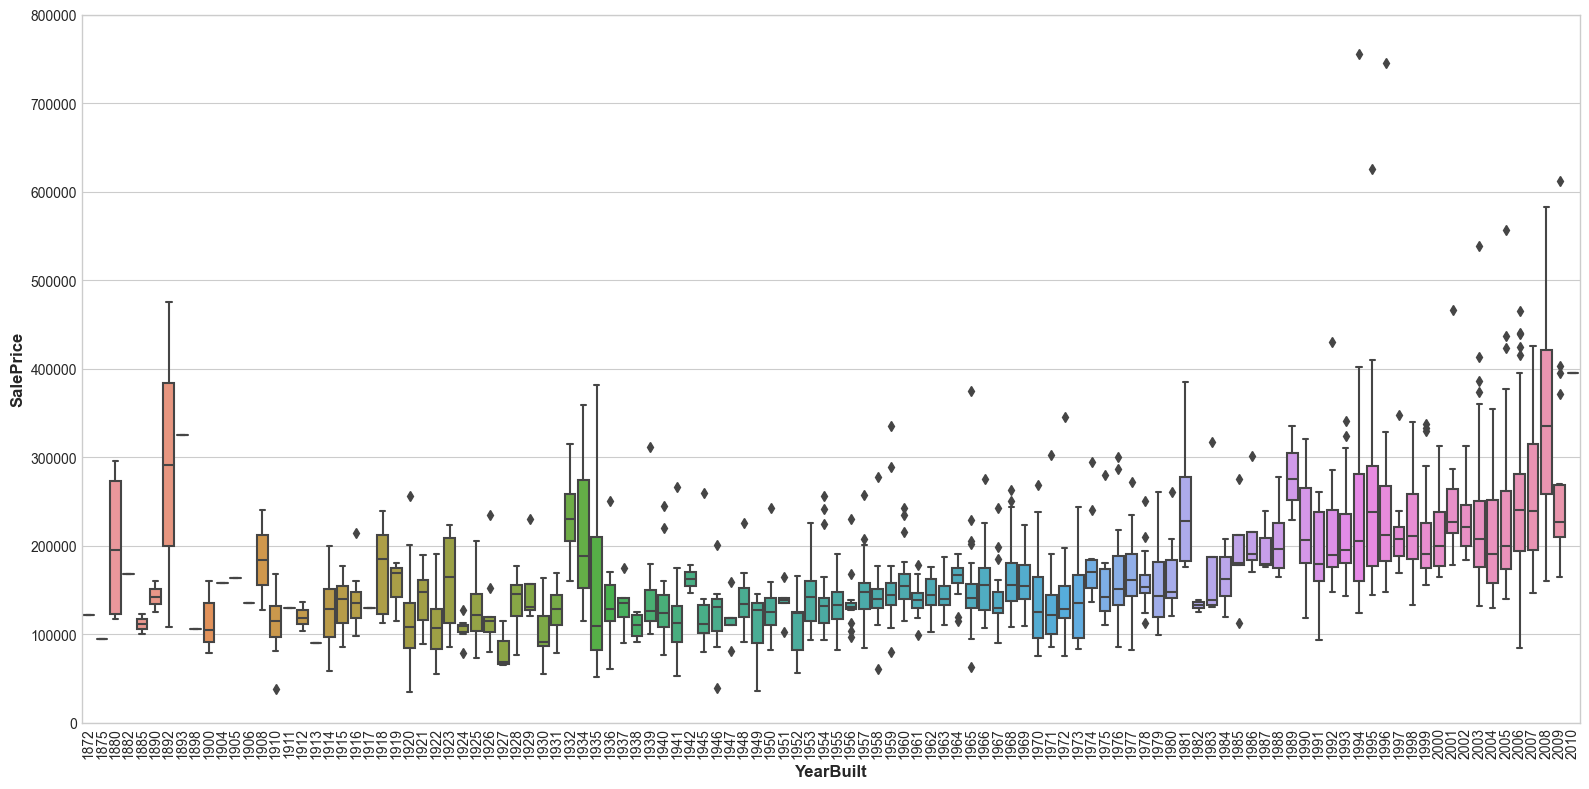

In [1435]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

# Забиним

In [1436]:
df['YearBuilt_binned'] = 'Rare'
df.loc[df['YearBuilt'] > 1900, 'YearBuilt_binned'] = 'Old'
df.loc[df['YearBuilt'] > 1980, 'YearBuilt_binned'] = 'New'

In [1437]:
df['YearBuilt_binned'].value_counts()

Old     1658
New     1206
Rare      55
Name: YearBuilt_binned, dtype: int64

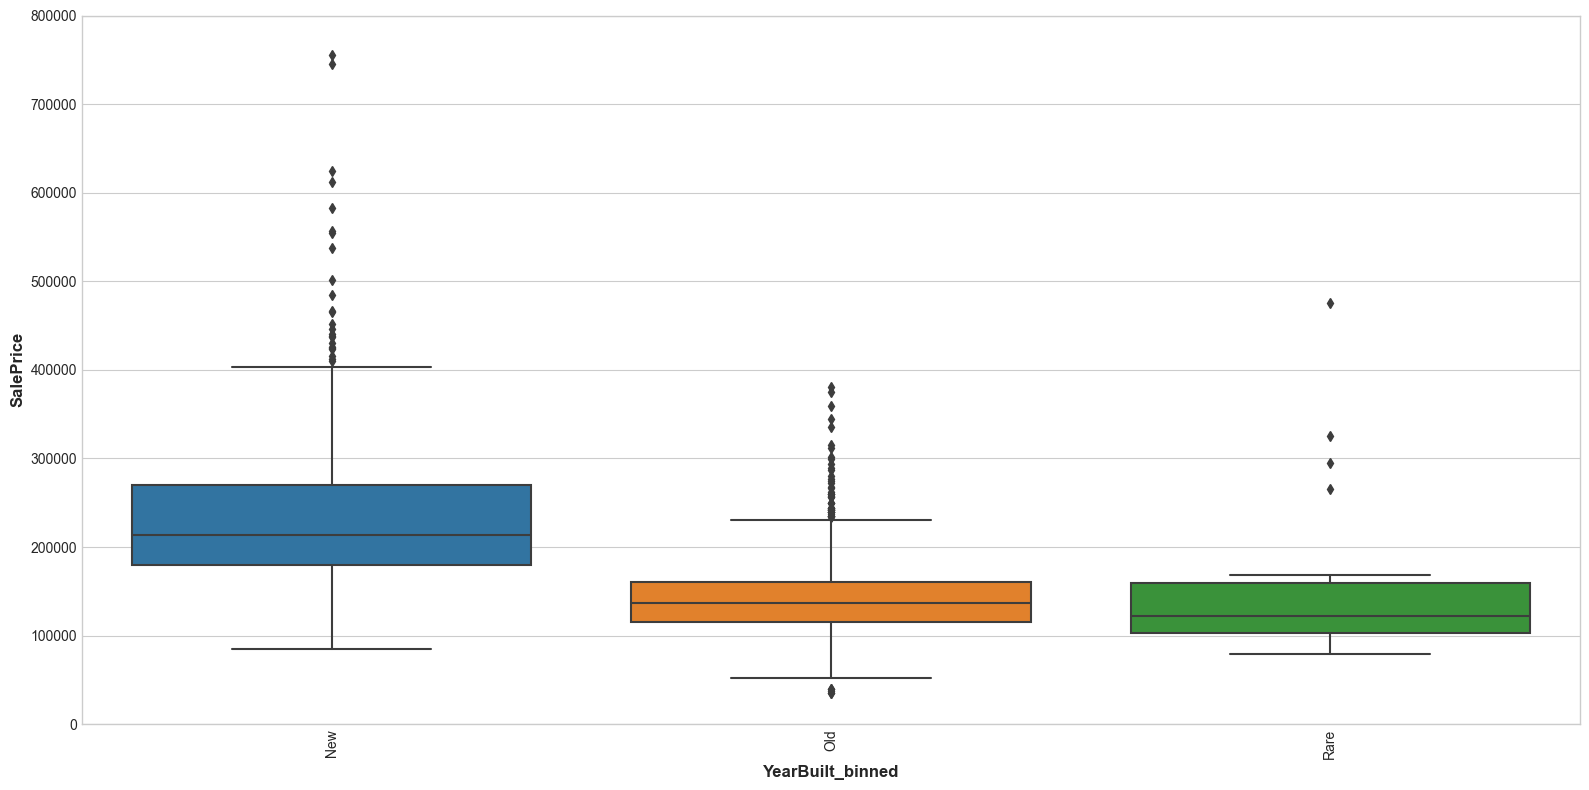

In [1438]:
X_train = df[:df_train.shape[0]]
var = 'YearBuilt_binned'
data = pd.concat([X_train['SalePrice'], X_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

In [1439]:
df['YearBuilt_binned'] = 'Rare'
df.loc[df['YearBuilt'] > 1975, 'YearBuilt_binned'] = 'New'

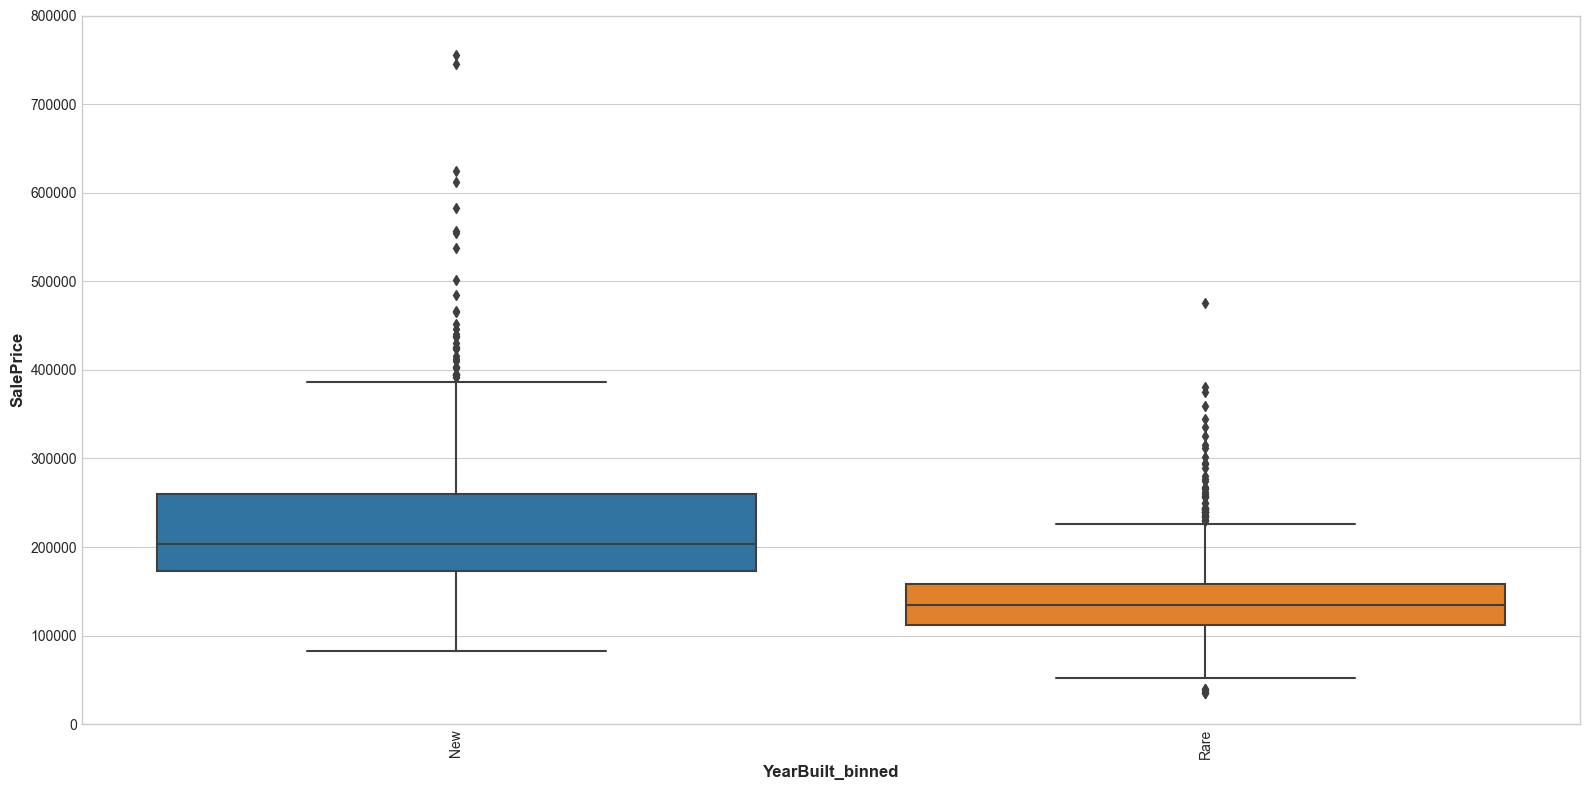

In [1440]:
X_train = df[:df_train.shape[0]]
var = 'YearBuilt_binned'
data = pd.concat([X_train['SalePrice'], X_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

In [1441]:
df.loc[df['YearBuilt_binned'] == 'Rare', 'YearBuilt_binned'] = df.loc[df['YearBuilt_binned'] == 'Rare', 'SalePrice'].mean()
df.loc[df['YearBuilt_binned'] == 'New', 'YearBuilt_binned'] = df.loc[df['YearBuilt_binned'] == 'New', 'SalePrice'].mean()

In [1442]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,YearBuilt_binned
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.00000,202787.967665
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.00000,202787.967665
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.00000,202787.967665
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.00000,160767.489185
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.00000,202787.967665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,6,2006,WD,Normal,180921.19589,160767.489185
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,4,2006,WD,Abnorml,180921.19589,160767.489185
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2006,WD,Abnorml,180921.19589,160767.489185


# New Features

In [1443]:
print(df['ExterQual'].isnull().sum())
print(df['ExterCond'].isnull().sum())
print(df['KitchenQual'].isnull().sum())
print(df['CentralAir'].isnull().sum())
print(df['Functional'].isnull().sum())
print(df['FireplaceQu'].isnull().sum())
print(df['PavedDrive'].isnull().sum())
print(df['MoSold'].isnull().sum())
print(df['YrSold'].isnull().sum())

0
0
1
0
2
1420
0
0
0


In [1444]:
# df.dropna(subset=['KitchenQual'], inplace=True)
# df.dropna(subset=['Functional'], inplace=True)
df['BsmtCond'].fillna('NA', inplace=True)
df['BsmtQual'].fillna('NA', inplace=True)

In [1445]:
# df.dropna(subset=['BsmtCond', 'BsmtQual'], inplace=True)
df['BsmtCond'].isnull().sum()
df['BsmtQual'].isnull().sum()
df['BsmtCond'] = df['BsmtCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0})
df['BsmtQual'] = df['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0})
df['Total_Bsmt_Quality'] = df['BsmtCond'] + df['BsmtQual']
# TODO remove because significantly reduces amount of records in dataset (81)

In [1446]:
df['KitchenQual'] = df['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
df['ExterQual'] = df['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
df['ExterCond'] = df['ExterCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
# df['FireplaceQu'] = df['FireplaceQu'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0})
df['CentralAir'] = df['CentralAir'].map({'Y': 1, 'N': 0})
df['Functional'] = df['Functional'].map({'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2':2, 'Sev':1, 'Sav':0})
df['PavedDrive'] = df['PavedDrive'].map({'Y': 2, 'P': 1, 'N':0})

In [1447]:
df["HighQualSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
df['Total_Home_Quality'] = df['OverallQual'] + df['OverallCond']
df['Home_Last_Update'] = df['YearRemodAdd'].apply(lambda x: x if x is not np.nan else df['YearBuilt'])
df['Total_Exter_Quality'] = df['ExterQual'] + df['ExterCond']
# df['DateSold'] = df['YrSold'].astype('str') + '/' + df['MoSold'].astype('str')
# df['DateSold'] = df['DateSold'].astype('datetime64').astype('int')
# df[['DateSold', 'MoSold', 'YrSold']]
df['has_garage'] = df['GarageType'].apply(lambda x: 1 if x is not np.nan else 0)
df['has_pool'] = df['PoolQC'].apply(lambda x: 1 if x is not np.nan else 0)
df['has_fence'] = df['Fence'].apply(lambda x: 1 if x is not np.nan else 0)

# Cat фичи

In [1448]:
df.shape

(2919, 89)

In [1449]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SalePrice,YearBuilt_binned,Total_Bsmt_Quality,HighQualSF,Total_Home_Quality,Home_Last_Update,Total_Exter_Quality,has_garage,has_pool,has_fence
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,208500.0,202787.967665,7,860.753438,12,2003,7,1,0,0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,181500.0,202787.967665,7,7.141245,14,1976,6,1,0,0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,223500.0,202787.967665,7,872.825460,12,2002,7,1,0,0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,140000.0,160767.489185,7,762.869014,12,1970,6,1,0,0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,250000.0,202787.967665,7,1060.044033,13,2000,7,1,0,0


## Label Encoding

In [1450]:
df['HeatingQC'].value_counts()

Ex    1493
TA     857
Gd     474
Fa      92
Po       3
Name: HeatingQC, dtype: int64

*    Ex   Excellent
*    Gd   Good
*    TA   Average/Typical
*    Fa   Fair
*    Po   Poor

In [1451]:
df['HeatingQC'].isnull().sum()

0

In [1452]:
df['HeatingQC'] = df['HeatingQC'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})

In [1453]:
df['Utilities'].isnull().sum()

2

In [1454]:
# df = df[df['Utilities'].notna()]


In [1455]:
df['Utilities'] = df['Utilities'].map({'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 'ELO':1})

In [1456]:
df['Street'].isnull().sum()

0

In [1457]:
df['Street'] = df['Street'].map({'Pave':2, 'Grvl':0})

In [1458]:
df['LandSlope'].isnull().sum()

0

## OHE

In [1459]:
full_df = pd.get_dummies(df)

In [1460]:
full_df = full_df.fillna(full_df.mean())

In [1461]:
full_df.shape

(2919, 268)

In [1462]:
full_df.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Utilities',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       ...
       'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial',
       'YearBuilt_binned_160767.48918538695',
       'YearBuilt_binned_202787.96766536206'],
      dtype='object', length=268)

In [1463]:
features = list(full_df.columns)
features.remove('SalePrice')

In [1464]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SalePrice,YearBuilt_binned,Total_Bsmt_Quality,HighQualSF,Total_Home_Quality,Home_Last_Update,Total_Exter_Quality,has_garage,has_pool,has_fence
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,2,NaN,Reg,Lvl,4.0,Inside,...,208500.00000,202787.967665,7,860.753438,12,2003,7,1,0,0
2,20,RL,80.0,9600,2,NaN,Reg,Lvl,4.0,FR2,...,181500.00000,202787.967665,7,7.141245,14,1976,6,1,0,0
3,60,RL,68.0,11250,2,NaN,IR1,Lvl,4.0,Inside,...,223500.00000,202787.967665,7,872.825460,12,2002,7,1,0,0
4,70,RL,60.0,9550,2,NaN,IR1,Lvl,4.0,Corner,...,140000.00000,160767.489185,7,762.869014,12,1970,6,1,0,0
5,60,RL,84.0,14260,2,NaN,IR1,Lvl,4.0,FR2,...,250000.00000,202787.967665,7,1060.044033,13,2000,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,2,NaN,Reg,Lvl,4.0,Inside,...,180921.19589,160767.489185,6,552.304449,11,1970,6,0,0,0
2916,160,RM,21.0,1894,2,NaN,Reg,Lvl,4.0,Inside,...,180921.19589,160767.489185,6,552.304449,9,1970,6,1,0,0
2917,20,RL,160.0,20000,2,NaN,Reg,Lvl,4.0,Inside,...,180921.19589,160767.489185,6,7.110696,12,1996,6,1,0,0


In [1465]:
#creating matrices for sklearn:
X_train = full_df[:df_train.shape[0]][features]
X_test = full_df[df_train.shape[0]:][features]
y = df_train['target']

# L1

In [1466]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [1467]:
rmse_cv(model_lasso).mean()

0.12959318827527538

In [1468]:
# rr = Ridge(alpha=10)
# rr.fit(X_train, y)
# np.sqrt(-cross_val_score(rr, X_train, y, cv=5, scoring="neg_mean_squared_error")).mean()
#
# y_pred = rr.predict(X_train)
# resid = y - y_pred
# mean_resid = resid.mean()
# std_resid = resid.std()
# z = (resid - mean_resid) / std_resid
# z = np.array(z)
# outliers1 = np.where(abs(z) > abs(z).std() * 3)[0]
# outliers1

In [1469]:
# outliers1.shape

In [1470]:
X_train

,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,YearBuilt_binned_160767.48918538695,YearBuilt_binned_202787.96766536206
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,2,4.0,7,5,2003,2003,196.0,...,0,1,0,0,0,0,1,0,0,1
2,20,80.0,9600,2,4.0,6,8,1976,1976,0.0,...,0,1,0,0,0,0,1,0,0,1
3,60,68.0,11250,2,4.0,7,5,2001,2002,162.0,...,0,1,0,0,0,0,1,0,0,1
4,70,60.0,9550,2,4.0,7,5,1915,1970,0.0,...,0,1,1,0,0,0,0,0,1,0
5,60,84.0,14260,2,4.0,8,5,2000,2000,350.0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,2,4.0,6,5,1999,2000,0.0,...,0,1,0,0,0,0,1,0,0,1
1457,20,85.0,13175,2,4.0,6,6,1978,1988,119.0,...,0,1,0,0,0,0,1,0,0,1
1458,70,66.0,9042,2,4.0,7,9,1941,2006,0.0,...,0,1,0,0,0,0,1,0,1,0


In [1471]:
# X_train = X_train.drop(outliers1.tolist())
# y = y.drop(outliers1.tolist())

# Посмотрим, отбросились ли фичи

In [1472]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [1473]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 114 variables and eliminated the other 153 variables


# Уберем незначимые фичи

In [1474]:
lasso_features = features.copy()
for feature in list(coef[coef == 0].index):
    lasso_features.remove(feature)

In [1475]:
sfs = SFS(LinearRegression(),
          k_features = 25,
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'neg_root_mean_squared_error',
          cv = 5,
          n_jobs= -1
         ).fit(X_train[lasso_features], y)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    6.1s finished

[2022-11-27 23:59:36] Features: 1/25 -- score: -0.2300632638605224[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  82 out of 113 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    0.6s finished

[2022-11-27 23:59:37] Features: 2/25 -- score: -0.19949921238328083[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  81 out of 112 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    0.5s finished

[2022-11-27 23:59:38] Features: 3/25 -- score: -0.18256907956593865[Para

In [1476]:
sfs.k_feature_names_

('LotArea',
 'OverallQual',
 'YearBuilt',
 'BsmtQual',
 'HeatingQC',
 '1stFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'Functional',
 'GarageCars',
 'ScreenPorch',
 'Total_Home_Quality',
 'MSZoning_C (all)',
 'MSZoning_RM',
 'Neighborhood_Crawfor',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Condition1_Norm',
 'BldgType_1Fam',
 'Exterior1st_BrkFace',
 'BsmtExposure_Gd',
 'BsmtFinType1_Unf',
 'SaleCondition_Abnorml')

In [1477]:
sfs = SFS(LinearRegression(),
          k_features =107,
          forward= False,
          floating = False,
          verbose= 2,
          scoring= 'neg_root_mean_squared_error',
          cv = 5,
          n_jobs= -1
         ).fit(X_train[lasso_features], y)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    2.9s finished

[2022-11-27 23:59:56] Features: 113/107 -- score: -0.1224696740996509[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    3.3s finished

[2022-11-27 23:59:59] Features: 112/107 -- score: -0.1210799127856335[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    3.8s finished

[2022-11-28 00:00:03] Features: 111/107 -- score: -0.12089611568845822[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)

In [1478]:
lr = LinearRegression()
lr.fit(X_train[list(sfs.k_feature_names_)], y)
rmse_cv(lr).mean()

0.1465571456601975

# Добавим Бустинг

In [1479]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

<AxesSubplot: >

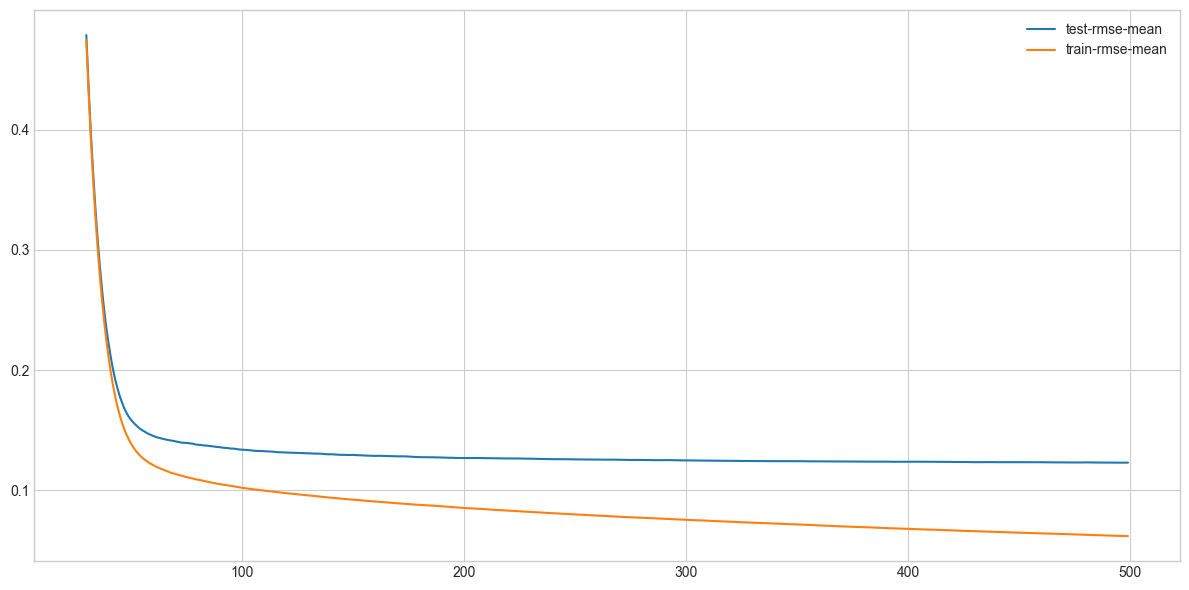

In [1480]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [1481]:
model_xgb = xgb.XGBRegressor(n_estimators=630, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
# xgb_grid = GridSearchCV(model_xgb,
#                         {'n_estimators': list(range(610, 700, 10))},
#                         cv = 2,
#                         n_jobs = 5,
#                         verbose=True)
# xgb_grid.fit(X_train, y)
# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=630, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [1482]:
rmse_cv(model_xgb).mean()

0.12380544613030516

In [1483]:
# dfdf = pd.DataFrame()
# dfdf['col'] = X_train.columns
# dfdf['importance'] = model_xgb.feature_importances_
# dfdf = dfdf.sort_values(by='importance', ascending=False)

In [1484]:
# plt.barh(dfdf['col'].head(20), dfdf['importance'].head(20))

In [1485]:
gbr = GradientBoostingRegressor(max_depth=4, n_estimators=150)
gbr.fit(X_train, y)
np.sqrt(-cross_val_score(gbr, X_train, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.12426621166177758

In [1486]:
lsr = Lasso(alpha=0.00047)
lsr.fit(X_train, y)
np.sqrt(-cross_val_score(lsr, X_train, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.1291579039354498

In [1487]:
rr = Ridge(alpha=13)
rr.fit(X_train, y)
np.sqrt(-cross_val_score(rr, X_train, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.1323072228718024

# Состакаем

In [1488]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

<AxesSubplot: xlabel='xgb', ylabel='lasso'>

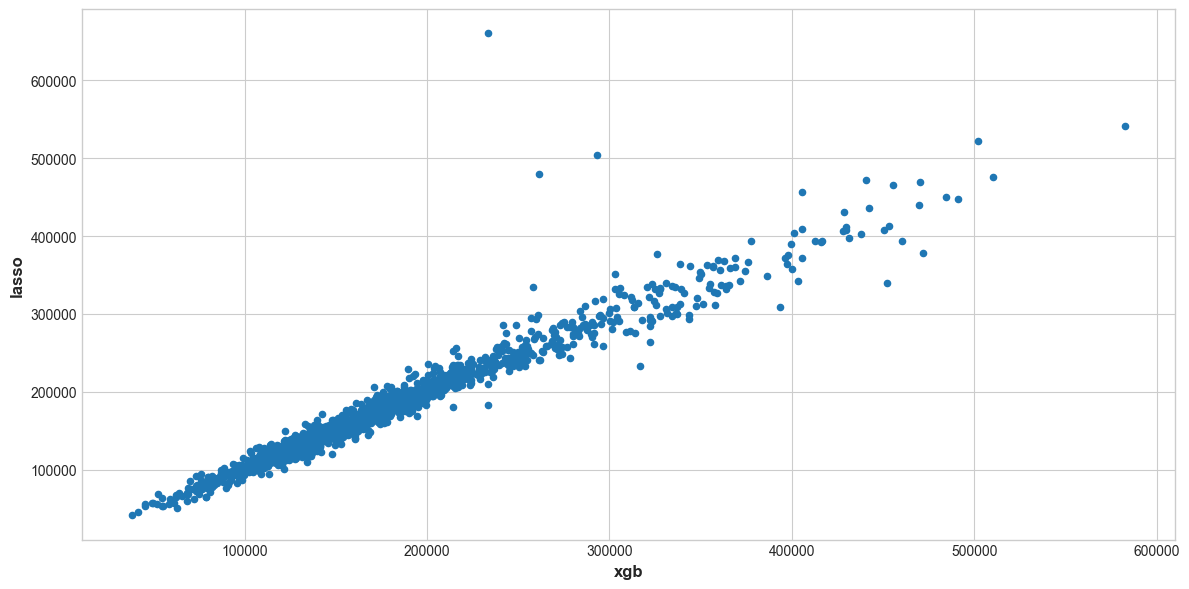

In [1489]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [1490]:
train_predict = 0.1 * np.expm1(gbr.predict(X_test)) + 0.3 * xgb_preds + 0.3 * np.expm1(lsr.predict(X_test)) + 0.3 * np.expm1(rr.predict(X_test))

In [1491]:
# preds = 0.5*lasso_preds + 0.5*xgb_preds

In [1492]:
# (rmse_cv(model_xgb) + rmse_cv(model_lasso)).mean() / 2

In [1493]:
# preds.shape

In [1494]:
# df_test.shape

In [1495]:
solution = pd.DataFrame({"id":df_test.index, "SalePrice":train_predict})
solution.to_csv("submission.csv", index = False)

In [1496]:
# # Train-Test split the data
#
# X_train,X_val,y_train,y_val = train_test_split(df_train,df_train['target'],test_size = 0.2,random_state=42)
#
# # Cat Boost Regressor
#
# cat = CatBoostRegressor()
# cat_model = cat.fit(X_train,y_train,
#                      eval_set = (X_val,y_val),
#                      plot=True,
#                      verbose = 0)

In [1497]:
# rmse_cv(cat_model).mean()